In [41]:
import tensorflow.keras as kf
import matplotlib.pyplot as plt
from CODE.utils import *
from CODE.models import create_2f_model


In [ ]:
window_size = 5
n_units = 256
corr_threshold = 0.2

df = load_dfs()
diff_df = df.pct_change(1).iloc[1:,:]

correlations = diff_df.corr().values[0]
filteres_ids = np.argwhere(abs(correlations)> corr_threshold).flatten()
diff_df = diff_df.iloc[:,filteres_ids]
print(diff_df.head())

array([], dtype=float64)

In [ ]:

file = 'FILES/Models/lstm_2f_model.hdf5'
rf_num = diff_df.values.shape[1]
input_shape = (window_size,rf_num)
model = create_2f_model(n_units, input_shape, file)

model.summary()


array([], dtype=float64)

In [56]:
X1, X2, Y = generate_windows_for_two_factor(diff_df, window_size)
X1[0:10]
X2[0:10]
Y[0:10]

array([], dtype=float64)

In [46]:
epochs = 100
for i in range(epochs):
    hist = model.fit(x=[X1, X2],
              y=Y,
              batch_size=512,
              verbose=0,
              epochs=1,
              validation_split=0.05,
              callbacks=[])
    if i > 0:
        if hist.history['val_loss'][-1] < val_loss:
            val_loss = hist.history['val_loss'][-1]
            print("New best val_loss: {}\t epoch: {}".format(val_loss,i))
            model.save_weights(file)
    else:
        val_loss = hist.history['val_loss'][-1]


ValueError: Error when checking input: expected input_7 to have 3 dimensions, but got array with shape (0, 1)

In [47]:

start = 100
window = 100
test_df = df.iloc[0:300,0].to_frame()
test_df.columns=['Actual']
test_df['Interp'] = test_df.iloc[:,0]
test_df['Interp'].iloc[start:start+window]=np.nan
test_df = test_df.interpolate()
start_value = test_df.iloc[start-1,0]
end_value = test_df.iloc[start+window,0]

In [48]:
Y_pred, Y_actual=list(), list()
for id in range(start, start+window):
    if id == start:
        x2 = X2[id].reshape(-1, window_size - 1, 1)
    x1 = X1[id].reshape(-1,window_size,input_shape[1]-1)
    Y_pred.append(model.predict([x1, x2]).flatten())
    Y_actual.append(Y[id].flatten())
    x2[0, :-1, 0] = x2[0, 1:, 0]
    x2[0,-1,0] = Y_pred[-1]

test_df['Predicted']=np.nan
fixed_values = np.array(Y_pred)+1
for i, value in enumerate(fixed_values):
    if i == 0:
        fixed_values[0]=value*start_value
    else:
        fixed_values[i]=fixed_values[i-1]*value
multiplier = end_value/fixed_values[-1]
#singlemultipliers = np.array([multiplier**(x/(window+1)) for x in range(window+2)])
singlemultipliers = np.array([multiplier**(0) for x in range(window+2)])
test_df['Predicted'].iloc[start:start+100]=fixed_values[:, 0]*singlemultipliers[:-2, 0]
test_df.plot()


IndexError: index 100 is out of bounds for axis 0 with size 0

In [49]:
import matplotlib.pyplot as plt
compare_df = test_df.dropna().copy()
compare_df['LinInterpDiffs']=abs(compare_df['Actual']-compare_df['Interp'])/compare_df['Actual']
compare_df['LstmInterpDiffs']=abs(compare_df['Actual']-compare_df['Predicted'])/compare_df['Actual']
print(compare_df.head())

KeyError: 'Predicted'

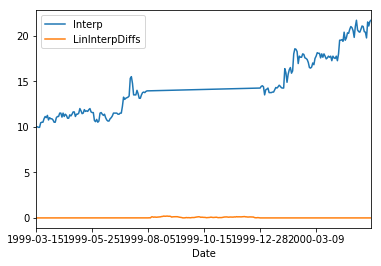

In [50]:
compare_df.iloc[:,-2:].plot()

In [51]:
print("Lstm Average Error: {}".format(compare_df['LstmInterpDiffs'].mean()))
print("Interpolation Average Error: {}".format(compare_df['LinInterpDiffs'].mean()))

KeyError: 'LstmInterpDiffs'

In [52]:
from scipy import stats

resLstm = stats.ks_2samp(compare_df['Actual'].values, compare_df['Predicted'].values)
print("Lstm KS result: \n \t - Statistic: {0} \n \t - pvalue: {1}".format(resLstm.statistic, resLstm.pvalue))
resInterp = stats.ks_2samp(compare_df['Actual'].values, compare_df['Interp'].values)
print("Interp KS result: \n \t - Statistic: {0} \n \t - pvalue: {1}".format(resInterp.statistic, resInterp.pvalue))

KeyError: 'Predicted'